In [28]:
import pandas as pd
import numpy as np
import cufflinks as cf
import matplotlib.pyplot as plt
import sqlite3
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm
from math import log, sqrt
from tqdm import tqdm
import QuantLib as ql

plt.style.use('ggplot')

In [29]:
CONVENTION = ql.Unadjusted
CALENDAR = ql.Mexico()
YIELD_BASIS = ql.Semiannual
TENOR = ql.Period(ql.Semiannual)
RULE = ql.DateGeneration.Backward
DAY_COUNT = ql.Actual360()
SETTLEMENT_DAYS = 2

In [462]:
def discretise_signal(z_scores, ol=-2, cl=-1, os=2, cs=1):
    position = pd.Series(0, index=z_scores.index)
    position.iloc[0] = np.where(z_scores.iloc[0] <= ol, 1, np.where(z_scores.iloc[0] >= os, -1, 0))
    for i in range(1, len(z_scores.index)):
        position.iloc[i] = np.where(z_scores.iloc[i] <= ol, 1, np.where(z_scores.iloc[i] >= os, -1,
            np.where((z_scores.iloc[i] < cl) & (position.iloc[i-1] == 1), 1,
            np.where((z_scores.iloc[i] > cs) & (position.iloc[i-1] == -1), -1, 0))))
    return position

def bond_sensitivities(bond, spot_curve_handle, tenors_years, spot_dates):
    bumps = [ql.SimpleQuote(0.00) for n in ([0] + tenors_years)]
    spreads = [ql.QuoteHandle(bump) for bump in bumps]
    spreaded_yts = ql.YieldTermStructureHandle(
        ql.SpreadedLinearZeroInterpolatedTermStructure(spot_curve_handle, spreads, spot_dates))
    spreaded_yts.enableExtrapolation()
    bond.setPricingEngine(ql.DiscountingBondEngine(spreaded_yts))
    price = bond.cleanPrice()
    senstivities = []
    for bump in bumps[1:]:
        bump.setValue(0.0001)
        senstivities.append(bond.cleanPrice() - price)
        bump.setValue(0.00)
    return senstivities


def trade_open(date, zero_curve, tenors, weights, instruments, fit_data):
    ql_date = ql.Date(date.day, date.month, date.year)
    ql.Settings.instance().evaluationDate = ql_date
    curve_tenors = list(zero_curve.index)
    curve_tenors_years = [int(s[1:]) for s in curve_tenors]
    spot_rates = [zero_curve.values[0]] + list(zero_curve.values)
    spot_dates = [ql_date + ql.Period(int(t), ql.Years) for t in ([0] + curve_tenors_years)]
    spot_curve = ql.ZeroCurve(spot_dates, spot_rates, DAY_COUNT, CALENDAR)
    spot_curve_handle = ql.YieldTermStructureHandle(spot_curve)
    sensitivities = instruments[instruments['PricingDate'] < date].copy()
    for i in sensitivities.index:
        bond = sensitivities.loc[i, 'QL bond']
        sensitivities.loc[i, curve_tenors] = bond_sensitivities(bond, spot_curve_handle, curve_tenors_years, spot_dates)
    issues = []
    notionals = []
    to_drop = fit_data[fit_data.abs() > 0.01].index
    sensitivities = sensitivities.drop(to_drop, axis=0, errors='ignore')
    for i, t in enumerate(tenors):
        issue = sensitivities[t].abs().idxmax()
        issues.append(issue)
        notionals.append(100 * weights[i]/sensitivities.loc[issue, t])
    #print(issues, notionals)
    return issues, notionals

    

In [586]:
class ButterflyStrategy():
    
    def __init__(self, tenors, weights, time_series, mu, sigma):
        self.tenors = tenors
        self.weights = weights.flatten()
        self.time_series = time_series
        self.mu = mu
        self.sigma = sigma
        
    def set_trading_rule(self, ol=-2, cl=-1, os=2, cs=1, ts=30):
        self.open_long = ol
        self.close_long = cl
        self.open_short = os
        self.close_short = cs
        self.time_stop = ts
        return self
    
    def get_position(self, instrument_universe, zc_curves, fit_data):
        self.instrument_universe = instrument_universe
        self.zc_curves = zc_curves
        self.fit_data = fit_data
        self.position = pd.DataFrame(data=0, index=self.time_series.index, columns=self.instrument_universe.index)
        self.trades = self.position.copy()
        columns_open = ['DateOpen', 'Tenors', 'Direction', 'VOpen']
        columns_close = ['DateClose', 'VClose']
        self.logs = pd.DataFrame(columns=columns_open + columns_close)
        signal = (self.time_series - self.mu)/self.sigma
        discrete_signal = discretise_signal(signal, self.open_long, self.close_long, self.open_short, self.close_short)
        if discrete_signal.iloc[0] != 0:
            issues, notionals = trade_open(self.time_series.index[0], self.zc_curves.iloc[0],
                                           self.tenors,
                                           discrete_signal.iloc[0] * self.weights,
                                           self.instrument_universe,
                                           self.fit_data.loc[self.time_series.index[0]])
            self.logs.loc[self.logs.shape[0], columns_open] = \
                [self.time_series.index[0], self.tenors, discrete_signal.iloc[0], self.time_series.iloc[0,0]]
            self.position.loc[self.time_series.index[0], issues] = notionals
        for i in range(1, len(self.time_series.index)-1):
            if (discrete_signal.iloc[i] == 0) & (discrete_signal.iloc[i-1] != 0):
                self.position.iloc[i] = 0
                self.logs.loc[self.logs.shape[0]-1, columns_close] = \
                    [self.time_series.index[i], self.time_series.iloc[i,0]]
            elif (discrete_signal.iloc[i] != 0) & (discrete_signal.iloc[i-1] == 0):
                direction = discrete_signal.iloc[i]
                issues, notionals = trade_open(self.time_series.index[i], self.zc_curves.iloc[i],
                                               self.tenors,
                                               direction * self.weights,
                                               self.instrument_universe,
                                               self.fit_data.loc[self.time_series.index[i]])
                self.logs.loc[self.logs.shape[0], columns_open] = \
                    [self.time_series.index[i], self.tenors, direction, self.time_series.iloc[i,0]]
                self.position.loc[self.time_series.index[i], issues] = notionals
            elif (discrete_signal.iloc[i] != 0) & (discrete_signal.iloc[i-1] == -discrete_signal.iloc[i]):
                self.logs.loc[self.logs.shape[0]-1, columns_close] = \
                    [self.time_series.index[i], self.time_series.iloc[i,0]]
                direction = discrete_signal.iloc[i]
                issues, notionals = trade_open(self.time_series.index[i], self.zc_curves.iloc[i],
                                               self.tenors,
                                               direction * self.weights,
                                               self.instrument_universe,
                                               self.fit_data.loc[self.time_series.index[i]])
                self.logs.loc[self.logs.shape[0], columns_open] = \
                    [self.time_series.index[i], self.tenors, direction, self.time_series.iloc[i,0]]
                self.position.loc[self.time_series.index[i], issues] = notionals
            elif (discrete_signal.iloc[i] != 0) & (discrete_signal.iloc[i-1] == discrete_signal.iloc[i]):
                if self.time_series.index[i] - self.logs.loc[self.logs.shape[0]-1, 'DateOpen'] > pd.Timedelta(days=self.time_stop):
                    self.logs.loc[self.logs.shape[0]-1, columns_close] = \
                        [self.time_series.index[i], self.time_series.iloc[i,0]]
                    self.position.iloc[i] = 0
                else:
                    self.position.iloc[i] = self.position.iloc[i-1]
            else:
                self.position.iloc[i] = self.position.iloc[i-1]
        self.trades = self.position.diff()
        self.trades.iloc[0] = self.position.iloc[0]
        if (self.logs.shape[0] > 0): 
            if (pd.isnull(self.logs.loc[self.logs.shape[0]-1, 'DateClose'])):
                self.logs.loc[self.logs.shape[0]-1, columns_close] = \
                    [self.time_series.index[-1], self.time_series.iloc[-1,0]]
        return self.position, self.trades, self.logs

In [365]:
pd.DataFrame(index=[1,2], columns=[1,2]).iloc[0,0]

float

In [721]:
#Fubnction for estimating buttefly weights based on PCA of zero curve
def get_pca_bf_weights(zc_data):
    cov = zc_data.cov()
    eig_vals, eig_vecs = np.linalg.eig(cov)
    permutation = np.argsort(-eig_vals)
    eig_vals = eig_vals[permutation]
    eig_vecs = eig_vecs[:, permutation]
    A = eig_vecs.T
    A[2] = [0, 1, 0]
    bf_weights = np.linalg.inv(A) @ np.array([[0], [0], [1]])
    return bf_weights

def get_pca_spread_weights(zc_data):
    cov = zc_data.cov()
    eig_vals, eig_vecs = np.linalg.eig(cov)
    permutation = np.argsort(-eig_vals)
    eig_vals = eig_vals[permutation]
    eig_vecs = eig_vecs[:, permutation]
    A = eig_vecs.T
    A[1] = [1, 0]
    spread_weights = np.linalg.inv(A) @ np.array([[0], [1]])
    return spread_weights

#Estimating Ornstein-Uhlenbeck parameters
def fit_ou_params(x):
    reg = sm.OLS(x[1:],sm.add_constant(x[:-1])).fit()
    theta = -log(reg.params[1])
    mu = reg.params[0] / (1 - reg.params[1])
    sigma_eq = np.std(reg.resid) / sqrt((1 - reg.params[1] ** 2))
    hl = log(2) / theta
    return theta, mu, sigma_eq, hl

In [32]:
def define_ql_bonds_bulk(instrument_ids, id_type='BBGID'):
    con = sqlite3.connect("./db/MBONOdata.db")
    str_ids = '('+str(instrument_ids)[1:-1]+')'
    bonds_sample = []
    query = """SELECT Instruments.%s, StaticSchedules.Date,
    StaticSchedules.Coupon, StaticSchedules.Principal
    FROM StaticSchedules INNER JOIN Instruments
    ON StaticSchedules.InstrumentID = Instruments.InstrumentID
    WHERE Instruments.%s in %s;""" % (id_type, id_type, str_ids)
    aggregate_schedules = pd.read_sql_query(query, con, parse_dates=['Date'])
    for b in instrument_ids:
        bond_schedule = aggregate_schedules[
            aggregate_schedules[id_type] == b].copy().sort_values('Date')
        bond_schedule['Days'] = (bond_schedule['Date'] -
                                 bond_schedule['Date'].shift(1)).dt.days
        schedule = ql.Schedule(bond_schedule['Date'].apply(
            ql.Date().from_date).values, CALENDAR,
                           CONVENTION, CONVENTION, TENOR, RULE, False)
        face_value = sum(bond_schedule['Principal'])
        coupons = ((360 / bond_schedule['Days']) * bond_schedule['Coupon'] /
                   face_value).dropna().values
        bonds_sample.append(ql.FixedRateBond(SETTLEMENT_DAYS, 100,
                                             schedule, coupons, DAY_COUNT))
    return bonds_sample

In [301]:
con = sqlite3.connect("./db/MBONOdata.db")
query = """SELECT DISTINCT BBGId, InstrumentID, Maturity, PricingDate from Instruments WHERE Maturity > 2010-01-01;"""
df = pd.read_sql_query(query, con, parse_dates=['PricingDate', 'Maturity'])

In [302]:
bonds = define_ql_bonds_bulk(list(df['BBGID'].values), id_type='BBGID')

In [168]:
query = """SELECT * from ZeroCurves;"""
df_zc = pd.read_sql_query(query, con, parse_dates=['Date'],
                                index_col='Date').sort_index()

In [170]:
df_zc.drop('ZeroCurveID', axis=1, inplace=True, errors='ignore')
df_zc

,Y1,Y2,Y3,Y5,Y10,Y20,Y30
Date,,,,,,,
2010-01-01,0.049139,0.059082,0.066124,0.074606,0.082525,0.090251,0.096812
2010-01-04,0.048706,0.059136,0.066494,0.075229,0.082800,0.090291,0.097765
2010-01-05,0.051110,0.058690,0.066621,0.075089,0.082451,0.089435,0.098320
2010-01-06,0.050152,0.059206,0.066920,0.074806,0.082246,0.089779,0.097143
2010-01-07,0.048686,0.059434,0.066632,0.074840,0.082336,0.089791,0.096544
...,...,...,...,...,...,...,...
2022-11-15,0.102418,0.095573,0.091949,0.089594,0.090971,0.092322,0.092245
2022-11-16,0.103162,0.095802,0.092006,0.089370,0.090138,0.091504,0.090072
2022-11-17,0.104394,0.097389,0.093661,0.090953,0.091636,0.092673,0.090511


In [691]:
df_zc = pd.read_csv('ZeroCurve.csv', parse_dates=[0], index_col=0).sort_index()
df_zc.columns = ['Y' + str(i) for i in df_zc.columns]
df_zc.index.name = 'Date'
df_zc.head()

,Y1,Y2,Y3,Y5,Y7,Y10,Y15,Y20,Y30
Date,,,,,,,,,
2010-01-01,0.049139,0.059082,0.066124,0.074606,0.079008,0.082525,0.086468,0.090251,0.096812
2010-01-04,0.048706,0.059136,0.066494,0.075229,0.079574,0.082800,0.086405,0.090291,0.097765
2010-01-05,0.051110,0.058690,0.066621,0.075089,0.079097,0.082451,0.086078,0.089435,0.098320
2010-01-06,0.050152,0.059206,0.066920,0.074806,0.078709,0.082246,0.086287,0.089779,0.097143
2010-01-07,0.048686,0.059434,0.066632,0.074840,0.078968,0.082336,0.086170,0.089791,0.096544


In [303]:
df['QL bond'] = bonds

In [304]:
df.set_index('BBGID', inplace=True)
df

,InstrumentID,Maturity,PricingDate,QL bond
BBGID,,,,
EC4262522 Corp,6,2011-07-14,2001-07-20,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...
EC6223613 Corp,10,2009-07-09,2002-07-12,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...
EC8045386 Corp,12,2009-12-24,2002-12-27,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...
EC8084633 Corp,13,2012-12-20,2003-01-03,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...
ED2028832 Corp,15,2023-12-07,2003-10-24,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...
ED2746086 Corp,16,2010-12-23,2003-12-26,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...
ED2816525 Corp,18,2013-12-19,2004-01-02,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...
ED2865670 Corp,19,2008-12-24,2004-01-09,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...
ED7597518 Corp,20,2014-12-18,2004-12-31,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...


In [429]:
query = """SELECT InstrumentID,  Date, Residual FROM FitData ;"""
agg_fit_data = pd.read_sql_query(query, con, parse_dates=['Date']).sort_values(['Date'])
fit_data = agg_fit_data.pivot_table(index='Date', columns='InstrumentID', values='Residual')
fit_data.columns = [df.index[df['InstrumentID'] == c][0] for c in fit_data.columns]
fit_data.head()

,EC4262522 Corp,EC8084633 Corp,ED2028832 Corp,ED2746086 Corp,ED2816525 Corp,ED7597518 Corp,ED7791103 Corp,ED7894840 Corp,EF2270975 Corp,EF5478096 Corp,...,EK1693424 Corp,EI7361336 Corp,QJ1649335 Corp,AM7523740 Corp,AS2511341 Corp,AX6352725 Corp,ZR8833868 Corp,BR4592233 Corp,BS4948482 Corp,BX4963407 Corp
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,-0.004205,0.000866,0.000246,0.001868,-0.000460,-0.000070,-0.000353,-0.003555,-0.001657,0.001410,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,-0.004120,0.001318,-0.000007,0.002118,-0.000227,-0.000095,-0.000196,-0.003388,-0.001114,0.000812,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,-0.004285,0.001036,-0.000109,-0.000957,-0.000428,-0.000060,-0.000277,-0.003048,-0.000915,0.000322,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,-0.004713,0.000510,-0.000162,0.000188,-0.000374,0.000061,-0.000439,-0.003443,-0.000682,0.000156,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,-0.004839,0.000492,-0.000138,0.002286,-0.000367,-0.000046,-0.000309,-0.003523,-0.000962,0.000314,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [449]:
idx_to_drop = fit_data.loc['2015-01-02'][(fit_data.loc['2015-01-02'].abs() > 0.001)].index
fit_data.drop(idx_to_drop, axis=1, errors='ignore')

,EC4262522 Corp,EC8084633 Corp,ED2028832 Corp,ED2746086 Corp,ED2816525 Corp,ED7597518 Corp,ED7791103 Corp,ED7894840 Corp,EF2270975 Corp,EF5478096 Corp,...,EK1693424 Corp,EI7361336 Corp,QJ1649335 Corp,AM7523740 Corp,AS2511341 Corp,AX6352725 Corp,ZR8833868 Corp,BR4592233 Corp,BS4948482 Corp,BX4963407 Corp
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,-0.004205,0.000866,0.000246,0.001868,-0.000460,-0.000070,-0.000353,-0.003555,-0.001657,0.001410,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,-0.004120,0.001318,-0.000007,0.002118,-0.000227,-0.000095,-0.000196,-0.003388,-0.001114,0.000812,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,-0.004285,0.001036,-0.000109,-0.000957,-0.000428,-0.000060,-0.000277,-0.003048,-0.000915,0.000322,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,-0.004713,0.000510,-0.000162,0.000188,-0.000374,0.000061,-0.000439,-0.003443,-0.000682,0.000156,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,-0.004839,0.000492,-0.000138,0.002286,-0.000367,-0.000046,-0.000309,-0.003523,-0.000962,0.000314,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-15,NaN,NaN,-0.000015,NaN,NaN,NaN,0.000205,NaN,NaN,NaN,...,-0.000325,NaN,-0.000028,-0.000077,NaN,-0.000139,-0.009919,0.000140,0.001536,-0.000120
2022-11-16,NaN,NaN,0.000016,NaN,NaN,NaN,0.000152,NaN,NaN,NaN,...,-0.000264,NaN,0.000184,-0.000135,NaN,-0.000184,-0.011587,0.000257,0.001580,-0.000010
2022-11-17,NaN,NaN,-0.000014,NaN,NaN,NaN,-0.000023,NaN,NaN,NaN,...,-0.000236,NaN,0.000194,-0.000013,NaN,0.000035,-0.011858,0.000193,0.001447,-0.000072


In [210]:
new_df

BBGID,EC4262522 Corp,EC6223613 Corp,EC8045386 Corp,EC8084633 Corp,ED2028832 Corp,ED2746086 Corp,ED2816525 Corp,ED2865670 Corp,ED7597518 Corp,ED7791103 Corp,...,EK1693424 Corp,EI7361336 Corp,QJ1649335 Corp,AM7523740 Corp,AS2511341 Corp,AX6352725 Corp,ZR8833868 Corp,BR4592233 Corp,BS4948482 Corp,BX4963407 Corp
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,0,0,0,1.0,0,0,0,0,-0.437727,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-04,0,0,0,0.0,0,0,0,0,0.000000,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-05,0,0,0,0.0,0,0,0,0,0.000000,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-06,0,0,0,0.0,0,0,0,0,0.000000,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-07,0,0,0,0.0,0,0,0,0,0.000000,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-15,0,0,0,0.0,0,0,0,0,0.000000,0,...,0,0,0,0,0,0,0,0,0,0
2022-11-16,0,0,0,0.0,0,0,0,0,0.000000,0,...,0,0,0,0,0,0,0,0,0,0
2022-11-17,0,0,0,0.0,0,0,0,0,0.000000,0,...,0,0,0,0,0,0,0,0,0,0


In [118]:
tenors = ['Y2', 'Y3', 'Y5', 'Y10', 'Y20']
tenors_years = [0, 2, 3, 5, 10, 20]

d = df_zc.index[0]
ql_d = ql.Date().from_date(d)
bond = bonds[-2]

<BarContainer object of 6 artists>

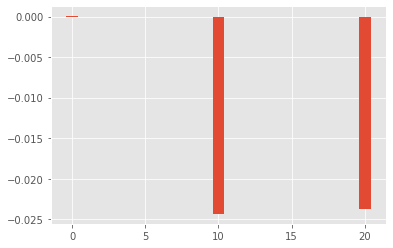

In [120]:
ql.Settings.instance().evaluationDate = ql_d
spot_rates = [0] + list(df_zc.loc[d, tenors] / 100)
spot_dates = [ql_d + ql.Period(int(t), ql.Years) for t in tenors_years]
spot_curve = ql.ZeroCurve(spot_dates, spot_rates, DAY_COUNT, CALENDAR)
spot_curve_handle = ql.YieldTermStructureHandle(spot_curve)

bumps = [ql.SimpleQuote(0.00) for n in tenors_years]
spreads = [ql.QuoteHandle(bump) for bump in bumps]
spreaded_yts = ql.YieldTermStructureHandle(
    ql.SpreadedLinearZeroInterpolatedTermStructure(spot_curve_handle, spreads, spot_dates))
spreaded_yts.enableExtrapolation()
bond.setPricingEngine(ql.DiscountingBondEngine(spreaded_yts))
price = bond.cleanPrice()
senstivities = []
for bump in bumps:
    bump.setValue(0.0001)
    senstivities.append(bond.cleanPrice() - price)
    bump.setValue(0.00)
plt.bar(tenors_years, senstivities)

In [128]:
np.array(senstivities) / max(abs(np.array(senstivities)))

array([ 1.44483280e-03,  7.96050702e-06,  0.00000000e+00,  0.00000000e+00,
       -1.00000000e+00, -9.76413902e-01])

In [130]:
spot_curve_handle

<QuantLib.QuantLib.YieldTermStructureHandle; proxy of <Swig Object of type 'Handle< YieldTermStructure > *' at 0x7fad1d5709c0> >

In [131]:
def bond_sensitivities(bond, spot_curve_handle, tenors_years):
    bumps = [ql.SimpleQuote(0.00) for n in ([0] + tenors_years)]
    spreads = [ql.QuoteHandle(bump) for bump in bumps]
    spreaded_yts = ql.YieldTermStructureHandle(
        ql.SpreadedLinearZeroInterpolatedTermStructure(spot_curve_handle, spreads, spot_dates))
    spreaded_yts.enableExtrapolation()
    bond.setPricingEngine(ql.DiscountingBondEngine(spreaded_yts))
    price = bond.cleanPrice()
    senstivities = []
    for bump in bumps:
        bump.setValue(0.0001)
        senstivities.append(bond.cleanPrice() - price)
        bump.setValue(0.00)
    return senstivities


In [136]:
for i in df.index:
    bond = df.loc[i, 'QL bond']
    df.loc[i, tenors] = bond_sensitivities(bond, spot_curve_handle, tenors_years)[1:]

In [165]:
df_zc.drop(['ZeroCurveID'], axis=1, inplace=True, errors='ignore')
df_zc.loc[d]

Y1     4.913937
Y2     5.908236
Y3     6.612402
Y5     7.460579
Y10    8.252452
Y20    9.025093
Y30    9.681220
Name: 2010-01-01 00:00:00, dtype: float64

In [160]:
df_zc.columns

Index(['ZeroCurveID', 'Y1', 'Y2', 'Y3', 'Y5', 'Y10', 'Y20', 'Y30'], dtype='object')

In [196]:
df_zc.loc[d, ['Y2', 'Y3', 'Y5']]

Y2    0.059082
Y3    0.066124
Y5    0.074606
Name: 2010-01-01 00:00:00, dtype: float64

In [804]:
tenors = ['Y2', 'Y3', 'Y5', 'Y7', 'Y10', 'Y15', 'Y20']
#tenors = ['Y3', 'Y5', 'Y10']

lookback_years = 5
test_years = 1
p_val_crit = 0.1
hl_crit = 20
sigma_crit = 0.0003
z_ol = -2
z_cl = -0.5
z_os = 2
z_cs = 0.5
trading_costs = 0.00005

eoy = pd.date_range(end=df_zc.index[-1], start = df_zc.index[0], freq='BY')
df_pca_position = pd.DataFrame(data=0, index=df_zc[df_zc.index > eoy[lookback_years-1]].index, columns=df.index)
df_pca_trades = df_pca_position.copy()
df_logs = pd.DataFrame()
                
for i in tqdm(range(lookback_years-1, len(eoy), 1)):
    idx = pd.bdate_range(start=eoy[i] + pd.tseries.offsets.DateOffset(years=-lookback_years), end=eoy[i])
    train_idx = df_zc.index.intersection(idx)
    idx = pd.bdate_range(end=eoy[i] + pd.tseries.offsets.DateOffset(years=test_years),
                        start=eoy[i] + pd.tseries.offsets.DateOffset(days=1))
    test_idx = df_zc.index.intersection(idx)
    for j, t1 in enumerate(tenors):
        for k, t2 in enumerate(tenors[j+1:j+2]):
            for t3 in tenors[j+k+2:j+k+3]:
                pca_bf_weights = get_pca_bf_weights(df_zc.loc[train_idx, [t1, t2, t3]])
                pca_bf_ts = df_zc.loc[train_idx, [t1, t2, t3]].dot(pca_bf_weights)
                if adfuller(pca_bf_ts)[1] < p_val_crit:
                    _, mu, sigma_eq, hl  = fit_ou_params(pca_bf_ts.values)
                    if (hl < hl_crit) & (sigma_eq > sigma_crit):
                        print(t1, t2, t3, int(hl), int(10000*sigma_eq))
                        pca_bf_test = df_zc.loc[test_idx, [t1, t2, t3]].dot(pca_bf_weights)
                        strategy = ButterflyStrategy([t1, t2, t3], pca_bf_weights, pca_bf_test, mu, sigma_eq)
                        strategy.set_trading_rule(z_ol, z_cl, z_os, z_cs, ts=3*hl_crit)
                        position, trades, logs = strategy.get_position(df, df_zc, fit_data)
                        df_pca_position.loc[test_idx] += position
                        df_pca_trades.loc[test_idx] += trades
                        df_logs = pd.concat([df_logs, logs], axis=0)


  0%|          | 0/8 [00:00<?, ?it/s]

Y2 Y3 Y5 1 4
Y3 Y5 Y7 5 3
Y10 Y15 Y20 2 5


 12%|█▎        | 1/8 [00:05<00:35,  5.10s/it]

Y2 Y3 Y5 1 3
Y3 Y5 Y7 6 4
Y10 Y15 Y20 2 5


 25%|██▌       | 2/8 [00:09<00:26,  4.41s/it]

Y2 Y3 Y5 1 4
Y3 Y5 Y7 4 3
Y10 Y15 Y20 1 4


 38%|███▊      | 3/8 [00:11<00:17,  3.54s/it]

Y2 Y3 Y5 1 4
Y3 Y5 Y7 3 3
Y7 Y10 Y15 5 4
Y10 Y15 Y20 1 4


 50%|█████     | 4/8 [00:15<00:14,  3.65s/it]

Y2 Y3 Y5 1 4
Y7 Y10 Y15 2 3


 62%|██████▎   | 5/8 [00:17<00:08,  2.97s/it]

Y2 Y3 Y5 1 3


 75%|███████▌  | 6/8 [00:18<00:04,  2.49s/it]

Y2 Y3 Y5 2 4
Y3 Y5 Y7 8 3


 88%|████████▊ | 7/8 [00:22<00:03,  3.06s/it]

Y2 Y3 Y5 3 3
Y3 Y5 Y7 8 3
Y10 Y15 Y20 1 4


100%|██████████| 8/8 [00:26<00:00,  3.37s/it]


In [793]:
tenors = ['Y2', 'Y3', 'Y5', 'Y7', 'Y10', 'Y15', 'Y20']
#tenors = ['Y3', 'Y5', 'Y10']

lookback_years = 5
test_years = 1
p_val_crit = 0.1
hl_crit = 200
sigma_crit = 0.0001
z_ol = -2
z_cl = -0.5
z_os = 2
z_cs = 0.5
trading_costs = 0.00005

eoy = pd.date_range(end=df_zc.index[-1], start = df_zc.index[0], freq='BY')
df_pca_position = pd.DataFrame(data=0, index=df_zc[df_zc.index > eoy[lookback_years-1]].index, columns=df.index)
df_pca_trades = df_pca_position.copy()
df_logs = pd.DataFrame()
                
for i in tqdm(range(lookback_years-1, len(eoy), 1)):
    idx = pd.bdate_range(start=eoy[i] + pd.tseries.offsets.DateOffset(years=-lookback_years), end=eoy[i])
    train_idx = df_zc.index.intersection(idx)
    idx = pd.bdate_range(end=eoy[i] + pd.tseries.offsets.DateOffset(years=test_years),
                        start=eoy[i] + pd.tseries.offsets.DateOffset(days=1))
    test_idx = df_zc.index.intersection(idx)
    for j, t1 in enumerate(tenors):
        for k, t2 in enumerate(tenors[j+1:j+5]):
            pca_spread_weights = get_pca_spread_weights(df_zc.loc[train_idx, [t1, t2]])
            pca_spread_ts = df_zc.loc[train_idx, [t1, t2]].dot(pca_spread_weights)
            if adfuller(pca_spread_ts)[1] < p_val_crit:
                _, mu, sigma_eq, hl  = fit_ou_params(pca_spread_ts.values)
                if (hl < hl_crit) & (sigma_eq > sigma_crit):
                    print(t1, t2, int(hl), int(10000*sigma_eq))
                    pca_spread_test = df_zc.loc[test_idx, [t1, t2]].dot(pca_spread_weights)
                    strategy = ButterflyStrategy([t1, t2], pca_spread_weights, pca_spread_test, mu, sigma_eq)
                    strategy.set_trading_rule(z_ol, z_cl, z_os, z_cs, ts=3*hl_crit)
                    position, trades, logs = strategy.get_position(df, df_zc, fit_data)
                    df_pca_position.loc[test_idx] += position
                    df_pca_trades.loc[test_idx] += trades
                    df_logs = pd.concat([df_logs, logs], axis=0)


  0%|          | 0/8 [00:00<?, ?it/s]

Y5 Y10 37 25
Y5 Y15 39 39
Y5 Y20 18 50
Y7 Y10 25 14
Y7 Y15 25 31
Y10 Y15 15 20


 12%|█▎        | 1/8 [00:04<00:32,  4.66s/it]

Y5 Y15 50 32
Y7 Y10 25 12


 38%|███▊      | 3/8 [00:07<00:10,  2.08s/it]

Y2 Y3 5 15
Y2 Y5 20 43
Y2 Y7 44 67
Y3 Y5 35 24


 50%|█████     | 4/8 [00:11<00:11,  2.85s/it]

Y2 Y3 2 11
Y2 Y5 11 30
Y2 Y7 28 48
Y2 Y10 49 72
Y3 Y5 24 17
Y3 Y7 46 33
Y3 Y15 81 79
Y5 Y10 42 28
Y5 Y15 62 49
Y5 Y20 54 69
Y7 Y10 32 13
Y7 Y15 44 32
Y7 Y20 41 48
Y10 Y15 26 16
Y10 Y20 22 31
Y15 Y20 10 13


 62%|██████▎   | 5/8 [00:21<00:16,  5.36s/it]

Y2 Y3 6 11
Y2 Y7 47 46
Y3 Y15 85 60
Y5 Y15 53 34
Y5 Y20 50 43
Y7 Y10 28 10
Y7 Y15 28 21
Y7 Y20 30 29
Y10 Y15 14 11
Y10 Y20 15 19
Y15 Y20 8 8


 75%|███████▌  | 6/8 [00:37<00:17,  8.92s/it]

Y2 Y3 6 11
Y2 Y5 15 24
Y2 Y7 25 34
Y2 Y10 40 51
Y3 Y5 22 13
Y3 Y7 32 24
Y3 Y10 51 41
Y3 Y15 68 69
Y5 Y7 34 10
Y5 Y10 47 26
Y5 Y15 62 50
Y5 Y20 66 71
Y7 Y10 41 14
Y7 Y15 47 35
Y7 Y20 55 53
Y10 Y15 32 18


 88%|████████▊ | 7/8 [00:58<00:13, 13.09s/it]

Y2 Y5 32 28
Y2 Y7 43 39
Y2 Y10 50 58
Y3 Y5 24 15
Y3 Y7 34 27
Y3 Y10 48 46
Y3 Y15 58 82
Y5 Y7 33 11
Y5 Y10 43 28
Y5 Y15 54 58
Y5 Y20 26 89
Y7 Y10 39 15
Y7 Y15 45 40
Y7 Y20 22 64
Y10 Y15 30 21
Y10 Y20 14 39


100%|██████████| 8/8 [01:06<00:00,  8.25s/it]


In [805]:
(10000 * (df_logs['VClose'] - df_logs['VOpen']) * df_logs['Direction']).sum()

435.9581935180434

In [751]:
trades_num = pd.Series(0, index=df_pca_position.index)
for d in df_pca_position.index:
    trades_num.loc[d] = ((df_logs['DateOpen'] < d) & (df_logs['DateClose'] > d)).sum()
trades_num.iplot()

In [420]:
query = """SELECT InstrumentID,  Date, Price FROM MarketData ;"""
agg_price_data = pd.read_sql_query(query, con, parse_dates=['Date']).sort_values(['Date'])
price_data = agg_price_data.pivot_table(index='Date', columns='InstrumentID', values='Price')

In [421]:
price_data.columns = [df.index[df['InstrumentID'] == c][0] for c in price_data.columns]
price_data

,EC4262522 Corp,EC8045386 Corp,EC8084633 Corp,ED2028832 Corp,ED2746086 Corp,ED2816525 Corp,ED7597518 Corp,ED7791103 Corp,ED7894840 Corp,EF2270975 Corp,...,EK1693424 Corp,EI7361336 Corp,QJ1649335 Corp,AM7523740 Corp,AS2511341 Corp,AX6352725 Corp,ZR8833868 Corp,BR4592233 Corp,BS4948482 Corp,BX4963407 Corp
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,108.040,100.011,106.456,97.457,102.788,103.646,109.157,114.879,106.560,102.930,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,108.045,100.011,106.240,97.553,102.804,103.390,108.919,114.605,106.521,102.383,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,108.057,100.011,106.251,97.814,102.790,103.383,108.901,114.911,106.493,102.395,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,108.099,100.011,106.317,97.862,102.783,103.377,108.945,115.047,106.483,102.438,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,108.074,100.011,106.421,97.907,102.771,103.481,109.026,114.992,106.471,102.539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-15,100.108,100.011,100.011,97.691,100.010,100.013,100.062,100.546,100.013,100.022,...,89.575,99.993,90.101,87.735,100.005,97.057,98.959,87.158,90.383,87.199
2022-11-16,100.108,100.011,100.011,97.620,100.010,100.013,100.062,100.505,100.013,100.022,...,90.022,99.993,90.037,88.569,100.005,97.013,98.963,87.152,90.346,88.163
2022-11-17,100.108,100.011,100.011,97.514,100.010,100.013,100.062,100.229,100.013,100.022,...,88.971,99.993,89.611,87.364,100.005,96.732,98.984,86.659,90.086,87.194


In [806]:
pnl = (df_pca_position.shift(1) * price_data.diff() / 100).sum(axis=1)
pnl = pnl[pnl.index > eoy[lookback_years-1]]
pnl.cumsum().iplot()
print(pnl.mean() / pnl.std() * sqrt(260))

1.2540216087801521


In [807]:
sett_dates = []
for d in df_pca_position.reset_index()['Date'].apply(ql.Date().from_date):
    ql_d = CALENDAR.advance(d, SETTLEMENT_DAYS, ql.Days)
    sett_dates.append(ql_d)
sett_position = df_pca_position.copy()
sett_position.index = sett_dates
repo_rates = df_zc.loc[df_pca_position.index, ['Y1']]
repo_rates.index = sett_dates
repo_rates = repo_rates.iloc[:,0]
repo_cost = pd.DataFrame(data=0, index=df_pca_position.index, columns=df_pca_position.columns)
for i, d in enumerate(sett_dates[:-1]):
    days = (sett_dates[i+1] - d)
    repo_cost.iloc[i] = -(sett_position.iloc[i] * repo_rates.iloc[i] * days / 360)


In [797]:
dirty_prices = pd.DataFrame(data=0, index=df_pca_position.index, columns=df_pca_position.columns)
coupons = pd.DataFrame(data=0, index=df_pca_position.index, columns=df_pca_position.columns)
tcost = pd.DataFrame(data=0, index=df_pca_position.index, columns=df_pca_position.columns)
for b in price_data.columns:
    bond = df.loc[b, 'QL bond']
    coupon_dates = []
    coupon_amounts = []
    for c in bond.cashflows():
        coupon_dates.append(c.date())
        coupon_amounts.append(c.amount())
    coupon_dates = coupon_dates[:-1]
    coupon_amounts = coupon_amounts[:-1]
    for i, d in enumerate(dirty_prices.index):
        ql_d = ql.Date().from_date(d)
        ql.Settings.instance().evaluationDate = ql_d
        dirty_prices.loc[d, b] = price_data.loc[d, b] + bond.accruedAmount()
        if sett_dates[i] in coupon_dates:
            coupons.loc[d, b] = coupon_amounts[coupon_dates.index(sett_dates[i])]
        try:
            tcost.loc[d, b] = price_data.loc[d, b] - bond.cleanPrice(
                bond.bondYield(price_data.loc[d, b], DAY_COUNT, YIELD_BASIS, ql.Compounded) + 0.000025,
                DAY_COUNT, YIELD_BASIS, ql.Compounded)
        except:
            tcost.loc[d, b] = 0
        



In [808]:
coupons_received = df_pca_position * coupons / 100
coupons_received.sum(axis=1).cumsum().iplot()

In [811]:
pnl = ((df_pca_position.shift(1) * dirty_prices.diff() / 100)+repo_cost+coupons_received - 0 * tcost * df_pca_trades.abs()/100).sum(axis=1)
pnl = pnl[pnl.index > eoy[lookback_years-1]]
pnl.cumsum().iplot()
print(pnl.mean() / pnl.std() * sqrt(260))

1.1079163001305707


In [812]:
gr_bf_pnl = pnl.copy()

In [756]:
(tcost * df_pca_trades.abs()/100).sum(axis=1).cumsum().iplot()

In [777]:
pnl.std() * sqrt(260)

1059.6635200039527

In [759]:
bf_pnl = pnl.copy()

In [815]:
net_total_pnl = (net_bf_pnl + net_spd_pnl/39.5)
print(net_total_pnl.mean() / net_total_pnl.std() * sqrt(260))

1.0044978569185254


In [780]:
total_pnl.cumsum().iplot()

In [786]:
(total_pnl.mean() / (np.sqrt(np.sum(total_pnl[total_pnl < 0] ** 2) / len(total_pnl)))) * np.sqrt(261)

1.6912137670378795

In [789]:
(total_pnl.cumsum() - total_pnl.cumsum().cummax()).iplot()
(total_pnl.cumsum() - total_pnl.cumsum().cummax()).min()

-36.69935962442486

In [791]:
(np.sqrt(261)*total_pnl.rolling(261).mean() / total_pnl.rolling(261).std()).iplot()

In [832]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
plt.style.use('ggplot')
%matplotlib inline

              Before Costs After Costs
Avg Ann PNL          46.48       39.18
Ann Std Dev          38.91       38.93
Sharpe Ratio          1.19        1.01
Sortino Ratio         2.03        1.69
Max Drawdown        -34.79      -36.70
1D VaR (95%)         -2.43       -2.45


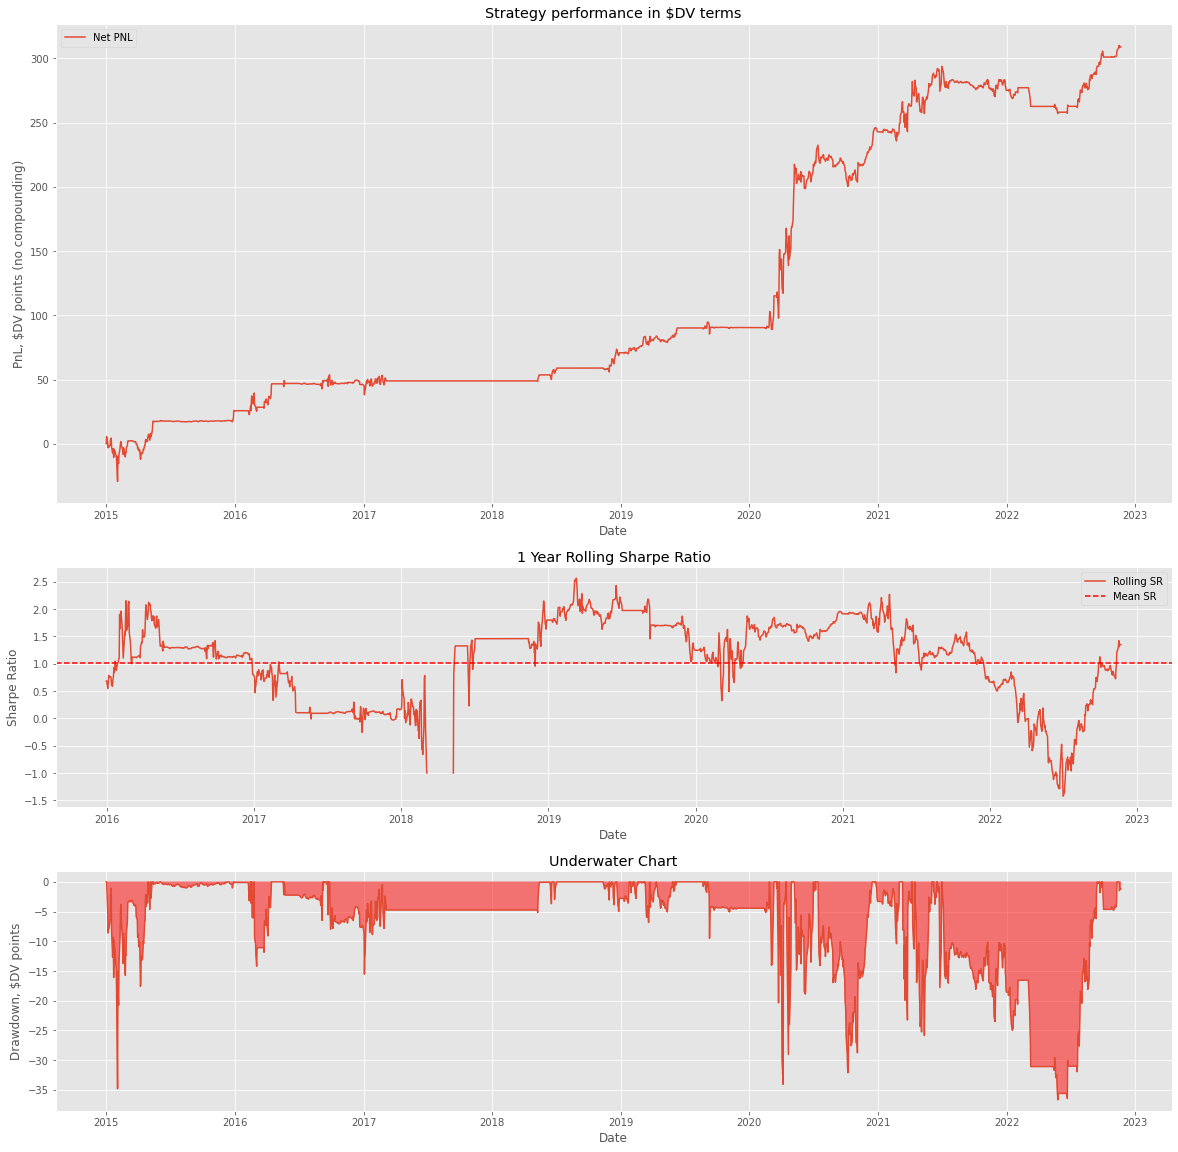

In [839]:
strat_stats = ['Avg Ann PNL', 'Ann Std Dev', 'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown', '1D VaR (95%)']
df_stats = pd.DataFrame(index=strat_stats, columns=['Before Costs', 'After Costs'])
total_pnl = [gr_total_pnl, net_total_pnl]
for i in range(2):
    df_stats.iloc[0, i] = total_pnl[i].mean() * 261
    df_stats.iloc[1, i] = total_pnl[i].std() * np.sqrt(261)
    df_stats.iloc[2, i] = df_stats.iloc[0, i] / df_stats.iloc[1, i]
    df_stats.iloc[3, i] = df_stats.iloc[0, i] / np.sqrt(np.sum(total_pnl[i][total_pnl[i] < 0] ** 2) / len(total_pnl[i])) \
    / np.sqrt(261)
    df_stats.iloc[4, i] = (total_pnl[i].cumsum() - total_pnl[i].cumsum().cummax()).min()
    df_stats.iloc[5, i] = total_pnl[i].quantile(0.05)
with pd.option_context('display.float_format', '{:,.2f}'.format):
    print(df_stats)
rolling_sharpe = np.sqrt(261) * (net_total_pnl.rolling(261).mean() / net_total_pnl.rolling(261).std())
fig, ax = plt.subplots(3,1, figsize=(20,20), gridspec_kw={'height_ratios': [2, 1, 1]})
ax[0].plot(net_total_pnl.cumsum(), label='Net PNL')
ax[0].set_title('Strategy performance in $DV terms')
ax[0].legend()
ax[0].xaxis.set_label_text('Date')
ax[0].yaxis.set_label_text('PnL, $DV points (no compounding)')
ax[1].set_title('1 Year Rolling Sharpe Ratio')
ax[1].plot(rolling_sharpe, label='Rolling SR')
ax[1].xaxis.set_label_text('Date')
ax[1].yaxis.set_label_text('Sharpe Ratio')
ax[1].axhline(df_stats.iloc[2,1], color='r', linestyle='--', label='Mean SR')
ax[1].legend()
ax[2].set_title('Underwater Chart')
ax[2].plot(net_total_pnl.cumsum() - net_total_pnl.cumsum().cummax())
ax[2].xaxis.set_label_text('Date')
ax[2].yaxis.set_label_text('Drawdown, $DV points')
ax[2].fill_between(net_total_pnl.index,
                   0,
                   net_total_pnl.cumsum() - net_total_pnl.cumsum().cummax(),
                   where=net_total_pnl.cumsum() - net_total_pnl.cumsum().cummax() < 0,
                   color='red',
                   alpha=0.5)
fig.show()

In [838]:
df_stats.T.to_clipboard()